In [1]:
import json
import os
import re

In [2]:
with open("./chatbot-arena-spoken-1turn-english-difference-voices.json") as f:
    raw_data = json.load(f)
gts = []
gt_mapping = {
    'model_a': 'A',
    'model_b': 'B',
    'tie': 'C',
    'tie (bothbad)': 'C'
}
for x in raw_data:
    gts.append(gt_mapping[x['winner']])
print("len:", len(gts))

len: 7824


In [3]:
def read_jsonl(file_path):
    data = []
    # Open and read the file line by line
    with open(file_path, 'r') as file:
        for line in file:
            # Parse each line as a JSON object
            json_obj = json.loads(line.strip())
            data.append(json_obj)
    print("len:", len(data))
    return data

In [4]:
def process_output(data):
    labels = []
    for x in data:
        response = x['response']
        response = response[-20:]
        labels += [extract_abc(response)]
    calculate_percentage(labels)
    return labels

def calculate_correciness(labels, gts, reverse=False):
    # assert len(labels) == len(gts)
    labels = labels[:len(gts)]
    correct, incorrect = 0, 0
    correct_AB, incorrect_AB = 0, 0
    for label, gt in zip(labels, gts):
        if reverse == True:
            if gt == 'A': 
                gt = 'B'
            elif gt == 'B': 
                gt = 'A'
        if label == gt:
            correct += 1
        else:
            incorrect += 1

        if label == 'A' or label == 'B':
            if label == gt:
                correct_AB += 1
            else:
                incorrect_AB += 1    
    print("correct:   {:.2f}%".format(correct/(correct+incorrect)*100))
    print("incorrect: {:.2f}%".format(incorrect/(correct+incorrect)*100))
    # print("correct_AB:   {:.2f}%".format(correct_AB/(correct_AB+incorrect_AB)*100))
    # print("incorrect_AB: {:.2f}%".format(incorrect_AB/(correct_AB+incorrect_AB)*100))

In [5]:
def extract_abc(text):
    pattern = r'\[\[(A|B|C)\]\]'
    
    # Search for the match
    match = re.search(pattern, text)
    
    if match:
        result = match.group(1)
        # print(f"Extracted value: {result}")
    else:
        result = "D"
    return result 

In [6]:
def calculate_percentage(arr):
    # Get the total number of items
    total_count = len(arr)
    
    # Create a dictionary to store counts of each unique item
    item_counts = {'A': 0, 'B': 0, 'C': 0, 'D': 0}
    
    for item in arr:
        item_counts[item] = item_counts.get(item, 0) + 1
    
    # Calculate percentages and store them in a dictionary
    percentages = {item: (count / total_count) * 100 for item, count in item_counts.items()}
    
    # Display the result
    print("---------------")
    for item, percentage in percentages.items():
        print(f"{item}: {percentage:.2f}%")
    print("---------------")

In [27]:
def measure_bias(preds_ab, preds_ba):
    n = min(len(preds_ab), len(preds_ba))
    preds_ab = preds_ab[:n]
    preds_ba = preds_ba[:n]
    biasA, biasB, consistentAB, consistentCC, other = 0, 0, 0, 0, 0
    for pred_ab, pred_ba in zip(preds_ab, preds_ba):
        if pred_ab == "A" and pred_ba == "A":
            biasA += 1
        elif pred_ab == "B" and pred_ba == "B":
            biasB += 1
        elif pred_ab == "A" and pred_ba == "B":
            consistentAB += 1  
        elif pred_ab == "B" and pred_ba == "A":
            consistentAB += 1
        elif pred_ab == "C" and pred_ba == "C":
            consistentCC += 1
        else:
            other += 1
    total = biasA + biasB + consistentAB # + consistentCC + other
    print("consistentAB: {:.2f}".format(consistentAB/total*100)) 
    # print("consistentCC: {:.2f}".format(consistentCC/total*100)) 
    print("biasA:      {:.2f}".format(biasA/total*100)) 
    print("biasB:      {:.2f}".format(biasB/total*100)) 
    # print("other:      {:.2f}".format(other/total*100)) 

In [29]:
text_text = process_output(read_jsonl("./experiments/chatbot-arena-7824/text-text-gemini1.5flash.jsonl"))
calculate_correciness(text_text, gts)
print("############################")
text_text_BA = process_output(read_jsonl("./experiments/chatbot-arena-7824/text-text-gemini1.5flash_BA.jsonl"))
calculate_correciness(text_text_BA, gts, reverse=True)
print("############################")
measure_bias(text_text, text_text_BA)

len: 7824
---------------
A: 53.55%
B: 41.86%
C: 4.58%
D: 0.01%
---------------
correct:   52.15%
incorrect: 47.85%
############################
len: 7824
---------------
A: 53.04%
B: 42.43%
C: 4.51%
D: 0.01%
---------------
correct:   52.35%
incorrect: 47.65%
############################
consistentAB: 77.32
biasA:      16.89
biasB:      5.79


In [30]:
0.5*(52.15+52.35)

52.25

In [31]:
audio_text = process_output(read_jsonl("./experiments/chatbot-arena-7824/audio-text-gemini1.5flash.jsonl"))
calculate_correciness(audio_text, gts)
print("############################")
audio_text_BA = process_output(read_jsonl("./experiments/chatbot-arena-7824/audio-text-gemini1.5flash_BA.jsonl"))
calculate_correciness(audio_text_BA, gts, reverse=True)
print("############################")
measure_bias(audio_text, audio_text_BA)

len: 7824
---------------
A: 54.19%
B: 40.76%
C: 5.02%
D: 0.03%
---------------
correct:   52.44%
incorrect: 47.56%
############################
len: 7824
---------------
A: 53.44%
B: 41.16%
C: 5.38%
D: 0.03%
---------------
correct:   51.71%
incorrect: 48.29%
############################
consistentAB: 76.61
biasA:      18.26
biasB:      5.13


In [32]:
0.5*(52.44+51.71)

52.075

In [35]:
audio_audio = process_output(read_jsonl("./experiments/chatbot-arena-7824/audio-audio-gemini1.5flash.jsonl"))
calculate_correciness(audio_audio, gts)
print("############################")
audio_audio_BA = process_output(read_jsonl("./experiments/chatbot-arena-7824/audio-audio-gemini1.5flash_BA.jsonl"))
calculate_correciness(audio_audio_BA, gts, reverse=True)
print("############################")
measure_bias(audio_audio, audio_audio_BA)

len: 7824
---------------
A: 62.87%
B: 34.01%
C: 3.09%
D: 0.03%
---------------
correct:   48.82%
incorrect: 51.18%
############################
len: 7824
---------------
A: 62.27%
B: 34.41%
C: 3.31%
D: 0.01%
---------------
correct:   48.40%
incorrect: 51.60%
############################
consistentAB: 64.18
biasA:      32.66
biasB:      3.16


In [37]:
0.5*(48.82+48.40)

48.61

In [39]:
asr_asr = process_output(read_jsonl("./experiments/chatbot-arena-7824/wpbase-wpbase-gemini1.5flash.jsonl"))
calculate_correciness(asr_asr, gts)
print("############################")
asr_asr_BA = process_output(read_jsonl("./experiments/chatbot-arena-7824/wpbase-wpbase-gemini1.5flash_BA.jsonl"))
calculate_correciness(asr_asr_BA, gts, reverse=True)
print("############################")
measure_bias(asr_asr, asr_asr_BA)

len: 7824
---------------
A: 52.63%
B: 42.82%
C: 4.54%
D: 0.01%
---------------
correct:   48.01%
incorrect: 51.99%
############################
len: 7824
---------------
A: 53.14%
B: 42.19%
C: 4.67%
D: 0.00%
---------------
correct:   47.84%
incorrect: 52.16%
############################
consistentAB: 74.61
biasA:      17.79
biasB:      7.60


In [40]:
0.5*(48.01+47.84)

47.925

In [28]:
calculate_correciness(text_text, audio_text)

correct:   87.53%
incorrect: 12.47%


In [29]:
calculate_correciness(text_text, audio_audio)

correct:   78.41%
incorrect: 21.59%


In [30]:
calculate_correciness(audio_text, audio_audio)

correct:   79.62%
incorrect: 20.38%


## System-level Correlation

In [15]:
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [42]:
def analyze_correlation_and_plot(list_a, list_b):
    # 1. Compute Pearson correlation
    pearson_corr, _ = stats.pearsonr(list_a, list_b)

    # 2. Compute Spearman correlation
    spearman_corr, pvalue = stats.spearmanr(list_a, list_b)

    # Print results
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")
    print("pvalue Spearman: {:.2e}".format(pvalue))

    # 4. Scatter plot with best-fit line
    plt.figure(figsize=(5, 4))
    plt.scatter(list_a, list_b, color='blue', label='Data points')

    # Best fit line
    coefficients = np.polyfit(list_a, list_b, 1)  # Linear fit (degree=1)
    poly = np.poly1d(coefficients)
    best_fit_line = poly(list_a)

    plt.plot(list_a, best_fit_line, color='red', label='Best Fit Line')
    plt.xlabel('Human Judge (Win Rate)')
    plt.ylabel('LLM Judge (Win Rate)')
    plt.title('Scatter Plot with Best Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

In [43]:
with open("./chatbot-arena-spoken-1turn-english-difference-voices.json") as f:
    raw_data = json.load(f)

In [44]:
uniq_systems = set([x['model_a'] for x in raw_data] + [x['model_b'] for x in raw_data])
uniq_systems = list(uniq_systems)
len(uniq_systems)

20

In [45]:
def system_level_analysis(path_ab, path_ba):
    data_ab = read_jsonl(path_ab)
    data_ba = read_jsonl(path_ba)
    n = min([len(data_ab), len(data_ba), len(raw_data)])
    print("n:", n)
    
    system_preds = {k: [] for k in uniq_systems}
    system_gts = {k: [] for k in uniq_systems}
    
    for i in range(n):
        x = raw_data[i]
        ab = data_ab[i]
        ba = data_ba[i]
        modelA, modelB = x['model_a'], x['model_b']
        
        label_ab = extract_abc(ab['response'][-20:])
        if label_ab == 'A':
            system_preds[modelA].append(1.0)
            system_preds[modelB].append(0.0)
        elif label_ab == 'B':
            system_preds[modelB].append(1.0)
            system_preds[modelA].append(0.0)
        else:
            system_preds[modelB].append(0.5)
            system_preds[modelA].append(0.5)
            
        label_ba = extract_abc(ba['response'][-20:])
        if label_ba == 'A':
            system_preds[modelB].append(1.0)
            system_preds[modelA].append(0.0)
        elif label_ba == 'B':
            system_preds[modelA].append(1.0)
            system_preds[modelB].append(0.0)
        else:
            system_preds[modelB].append(0.5)
            system_preds[modelA].append(0.5)
    
        if x['winner'] == 'model_a':
            system_gts[modelA].append(1.0)
            system_gts[modelB].append(0.0)
        elif x['winner'] == 'model_b':
            system_gts[modelB].append(1.0)
            system_gts[modelA].append(0.0)
        else:
            system_gts[modelA].append(0.5)
            system_gts[modelB].append(0.5)
            
    system_level_pred, system_level_gts = [], []
    for system, pred in system_preds.items():
        if len(pred) == 0:
            continue
        gts = system_gts[system]
        assert len(pred) == 2*len(gts)
        assert math.isnan(np.mean(pred)) is False
        system_level_pred.append(np.mean(pred))
        system_level_gts.append(np.mean(gts))
    analyze_correlation_and_plot(system_level_gts, system_level_pred)

len: 7824
len: 7824
n: 7824
Pearson Correlation: 0.964
Spearman Correlation: 0.961
pvalue Spearman: 1.76e-11


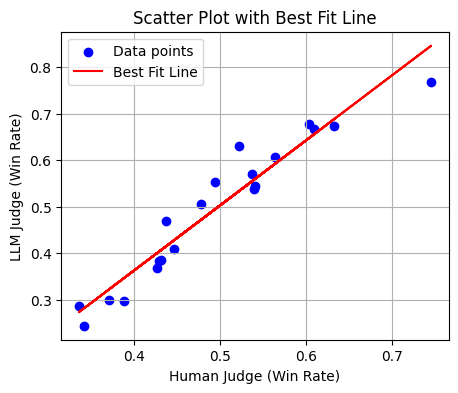

In [46]:
system_level_analysis("./experiments/chatbot-arena-7824/text-text-gemini1.5flash.jsonl", "./experiments/chatbot-arena-7824/text-text-gemini1.5flash_BA.jsonl")

len: 7824
len: 7824
n: 7824
Pearson Correlation: 0.960
Spearman Correlation: 0.970
pvalue Spearman: 1.71e-12


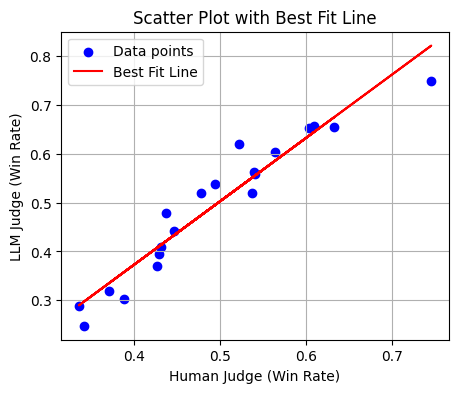

In [47]:
system_level_analysis("./experiments/chatbot-arena-7824/audio-text-gemini1.5flash.jsonl", "./experiments/chatbot-arena-7824/audio-text-gemini1.5flash_BA.jsonl")

len: 7824
len: 7824
n: 7824
Pearson Correlation: 0.945
Spearman Correlation: 0.949
pvalue Spearman: 1.88e-10


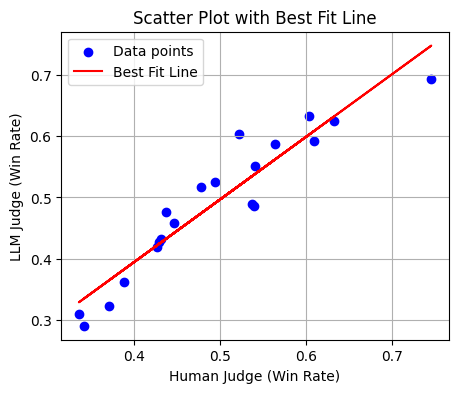

In [48]:
system_level_analysis("./experiments/chatbot-arena-7824/audio-audio-gemini1.5flash.jsonl", "./experiments/chatbot-arena-7824/audio-audio-gemini1.5flash_BA.jsonl")

len: 7824
len: 7824
n: 7824
Pearson Correlation: 0.919
Spearman Correlation: 0.895


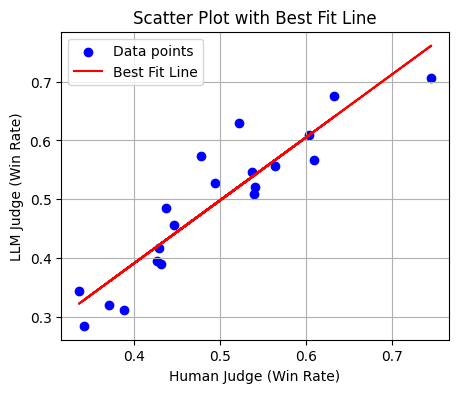

In [41]:
system_level_analysis("./experiments/chatbot-arena-7824/wpbase-wpbase-gemini1.5flash.jsonl", "./experiments/chatbot-arena-7824/wpbase-wpbase-gemini1.5flash_BA.jsonl")